In [1]:
# Preprocess

# The solution of "this TensorFlow binary was not compiled to use: AVX2"
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Step.1 Read input_data
import numpy as np
import tensorflow as tf

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

# import tensorflow.examples.tutorials.mnist.input_data as input_data
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Create common function

# Step.1: define weight function
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='W')

# Step.2: define bias function
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name='b')

# Step.3: define conv2d function
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

# Step.4: define max_pool_2x2 function
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

In [3]:
# Create Model

# Create Input Layer
with tf.name_scope('Input_Layer'):
    x = tf.placeholder("float", shape=[None, 784], name = 'x')
    x_image = tf.reshape(x, [-1, 28, 28, 1])

# Create CNN layer 1
with tf.name_scope('C1_Conv'):
    W1 = weight([5,5,1,16])
    b1 = bias([16])
    Conv1 = conv2d(x_image, W1) + b1
    C1_Conv = tf.nn.relu(Conv1)

# Create Pooling Layer 1
with tf.name_scope('C1_Pool'):
    C1_Pool = max_pool_2x2(C1_Conv)
    
# Create CNN layer 2
with tf.name_scope('C2_Conv'):
    W2 = weight([5,5,16,36])
    b2 = bias([36])
    Conv2 = conv2d(C1_Pool, W2) + b2
    C2_Conv = tf.nn.relu(Conv2)
    
# Create pooling layer 2
with tf.name_scope('C2_Pool'):
    C2_Pool = max_pool_2x2(C2_Conv)
    
# Create Flattern Layer
with tf.name_scope('D_Flat'):
    D_Flat = tf.reshape(C2_Pool, [-1, 1764])

# Create Hidden Layer
with tf.name_scope('D_Hidden_Layer'):
    W3 = weight([1764, 128])
    b3 = bias([128])
    D_Hidden = tf.nn.relu(tf.matmul(D_Flat, W3) + b3)
    D_Hidden_Dropout = tf.nn.dropout(D_Hidden, keep_prob = 0.8)

# Create Output Layer
with tf.name_scope('Output_Layer'):
    W4 = weight([128, 10])
    b4 = bias([10])
    y_predict = tf.nn.softmax(tf.matmul(D_Hidden_Dropout, W4) + b4)

In [4]:
# Define Train Method

with tf.name_scope('optimizer'):
    
    y_label = tf.placeholder(
        "float", shape=[None, 10], name = 'y_label'
    )
    
    loss_function = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits = y_predict, labels = y_label)
    )
    
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001).minimize(loss_function)

In [5]:
# Define Model Accuracy

with tf.name_scope("evaluate_model"):
    correct_prediction = tf.equal(
        tf.argmax(y_predict, 1), tf.argmax(y_label, 1)
    )
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [6]:
# Train

# Define Parameters
trainEpochs = 30
batchSize   = 100
totalBatchs = int(mnist.train.num_examples / batchSize)
epoch_list = []
accuracy_list = []
loss_list = []

from time import time
startTime = time()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training
for epoch in range(trainEpochs):
    for i in range(totalBatchs):
        batch_x, batch_y = mnist.train.next_batch(batchSize)
        sess.run(optimizer, feed_dict={x: batch_x, y_label: batch_y})
    
    loss, acc = sess.run(
        [loss_function, accuracy],
        feed_dict = {x: mnist.validation.images, 
                     y_label: mnist.validation.labels}
    )
    epoch_list.append(epoch)
    loss_list.append(loss)
    accuracy_list.append(acc)
    
    print("Train Epoch:", '%02d' % (epoch+1), 
          "Loss=", "{:.9f}".format(loss),
          " Accuracy=", acc
         )

duration = time() - startTime
print("Train Finished takes:", duration)

Train Epoch: 01 Loss= 1.586023092  Accuracy= 0.9008
Train Epoch: 02 Loss= 1.540244699  Accuracy= 0.9324
Train Epoch: 03 Loss= 1.524219871  Accuracy= 0.9466
Train Epoch: 04 Loss= 1.510160208  Accuracy= 0.9574
Train Epoch: 05 Loss= 1.505609989  Accuracy= 0.9606
Train Epoch: 06 Loss= 1.498371482  Accuracy= 0.9678
Train Epoch: 07 Loss= 1.495339274  Accuracy= 0.9702
Train Epoch: 08 Loss= 1.492941380  Accuracy= 0.9706
Train Epoch: 09 Loss= 1.489994168  Accuracy= 0.9738
Train Epoch: 10 Loss= 1.485996008  Accuracy= 0.9768
Train Epoch: 11 Loss= 1.486941934  Accuracy= 0.9764
Train Epoch: 12 Loss= 1.484110594  Accuracy= 0.9784
Train Epoch: 13 Loss= 1.483128071  Accuracy= 0.98
Train Epoch: 14 Loss= 1.484626651  Accuracy= 0.9786
Train Epoch: 15 Loss= 1.482619762  Accuracy= 0.9802
Train Epoch: 16 Loss= 1.481818914  Accuracy= 0.9814
Train Epoch: 17 Loss= 1.480987549  Accuracy= 0.9826
Train Epoch: 18 Loss= 1.480225444  Accuracy= 0.9826
Train Epoch: 19 Loss= 1.478805900  Accuracy= 0.9836
Train Epoch: 2

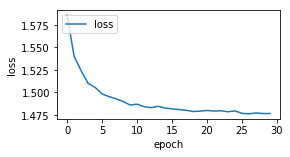

In [7]:
# Plot loss 

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(4, 2)  
plt.plot(epoch_list, loss_list, label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')

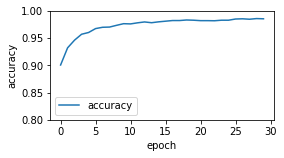

In [8]:
# Plot accuracy

plt.plot(epoch_list, accuracy_list, label = "accuracy")
fig = plt.gcf()
fig.set_size_inches(4, 2)
plt.ylim(0.8, 1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [9]:
# Evaluate Accuracy
print("Accuracy:", sess.run(
    accuracy, 
    feed_dict={x: mnist.test.images, y_label: mnist.test.labels}
))

Accuracy: 0.9867


In [10]:
# Run Prediction

# Execute prodiction
prediction_result = sess.run(
    tf.argmax(y_predict, 1),
    feed_dict = {x: mnist.test.images, y_label: mnist.test.labels}
)

# Prediction Result
prediction_result[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [11]:
# Define plot images function

def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
    
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num > 25: num = 25
    for i in range(0, num):
        ax = plt.subplot(5, 5, 1+i)
        
        ax.imshow(np.reshape(images[idx],(28,28)), cmap='binary')
        title = "label=" + str(np.argmax(labels[idx]))
        
        if len(prediction) > 0:
            title += ",predict=" + str(prediction[idx])
            
        ax.set_title(title, fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        idx += 1
    plt.show()

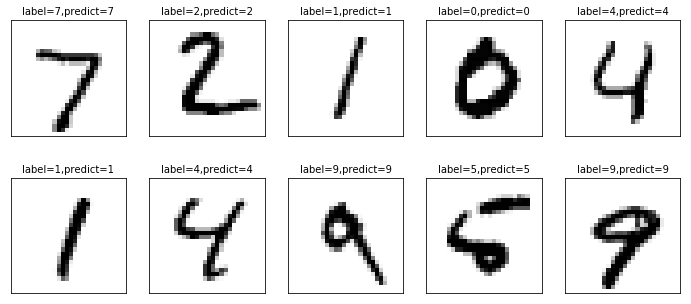

In [12]:
plot_images_labels_prediction(
    mnist.test.images,
    mnist.test.labels,
    prediction_result,
    0
)

In [13]:
# TensorBoard

merged = tf.summary.merge_all()
train_write = tf.summary.FileWriter('log/CNN', sess.graph)